In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from collections import defaultdict
import itertools
from urllib.parse import parse_qs
import glob
import matplotlib.pylab as plt
from collections import Counter
import collections
from nltk.tokenize import word_tokenize

In [ ]:
def get_job_links_page(page):
    base_url = "https://www.indeed.com/jobs?"
    params = {'q': 'data scientist', 
             'l': 'Boulder, CO'}
    

    # start = "https://www.indeed.com/jobs?q=Data+Scientist&l=Denver%2C+CO"
    # use a fake header
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    params['start'] = 20 * (page-1)

    page = requests.get(base_url, params=params, headers=headers)
    # test = requests.get(start, headers=headers)
    
    soup = BeautifulSoup(page.text, "html.parser")
    links = soup.find_all("a")
    
    # build a list of links
    some_links = []

    for l in links:
        try:
            hyperlink = l.attrs.get('href')
            if "/rc/clk?" in hyperlink:
                some_links.append(l.attrs.get('href'))
        except:
            pass
    
    job_links = ["https://www.indeed.com{}".format(x)
             for x in some_links
             ]
    
    return job_links


In [ ]:
links = [get_job_links_page(x) for x in range(1, 40)] # getting a link for 39 pages 

In [ ]:
len(links)

In [ ]:
merged = list(itertools.chain(*links))
len(merged)
merged[0] # getting a link for 39 pages 

In [ ]:
def get_filename_from_url(some_url):
    parsed = parse_qs(some_url)
    fccid =  parsed.get('fccid')[0]
    other_id = parsed.get('https://www.indeed.com/rc/clk?jk')[0]
    return fccid+other_id+ ".html"

In [ ]:
get_filename_from_url(merged[0]) # file name for each html file

In [ ]:
len(set([get_filename_from_url(x) for x in merged])) # the total number of html files(jobs) parsed and saved locally. 

In [ ]:
#downloading each html file as a soup object
def download_job_page(link):
    save_name = get_filename_from_url(link)
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    test = requests.get(link, headers=headers)
    soup = BeautifulSoup(test.text, "html.parser")
    
    with open('data_scienceBoulder_{}'.format(save_name), 'w') as f:
        f.write(str(soup))

In [ ]:
for link in tqdm(merged):
    try:
        download_job_page(link)
    except Exception as e:
        print(str(e), link)
    finally:
        time.sleep(1)


In [2]:
html = glob.glob('*.html')
len(html) # the total number of html files(jobs) parsed and saved locally. 

1528

In [3]:
html_divs = []

for html_file in html:
    with open(html_file, 'r',encoding="ISO-8859-1") as f:
        _data = BeautifulSoup(f.read(), "html.parser")
        try:
            has_span_job_summary = _data.find("span", id="job_summary").get_text()
            html_divs.append(has_span_job_summary)
        except:
            print('The job summary field does not exist.')
        
len(html_divs) # total numbers of job postings saved locally. 

The job summary field does not exist.
The job summary field does not exist.
The job summary field does not exist.
The job summary field does not exist.
The job summary field does not exist.
The job summary field does not exist.
The job summary field does not exist.


1521

In [4]:
jobs = pd.DataFrame(html_divs)
jobs.columns = ['job_summary']
jobs.head(20)

,job_summary
0,Data Analyst\nCommunity Reach Center (CRC) is ...
1,"Public Consulting Group, Inc. (PCG) is a leadi..."
2,Job Summary\nThe Department of Computer Scienc...
3,Department: Clinical Application Services\nHou...
4,Accelerate Your Career\nDrive global technolog...
5,Who We Are:\n\n\nBall Aerospace leads the way ...
6,"Job Summary\n\nUnder minimal supervision, desi..."
7,Data Engineer (multiple positions)\nDatalere t...
8,"Collect, review, and report on data.\nCollect ..."
9,"At FedEx Office, team members with a passion f..."


In [5]:
jobs.shape

(1521, 1)

In [41]:
df1=pd.read_csv('hacker_news.csv')
del df1['source']
df1.rename(columns={'desc': 'job_summary'}, inplace=True)
df1.head()

,job_summary
0,"Photofeeler (<a href=""https:&#x2F;&#x2F;www.ph..."
1,"Q-Branch Labs (<a href=""https:&#x2F;&#x2F;www...."
2,"Worldwide, REMOTE, full time or part time -- 1..."
3,"Lendable | Senior Software Engineers, Senior D..."
4,"Gambit Research Ltd (<a href=""http:&#x2F;&#x2F..."


In [42]:
all_jobs=pd.concat([df1,jobs])
all_jobs.shape

(4055, 1)

In [43]:
all_jobs.job_summary.unique().shape

(3695,)

In [44]:
def load_skills_list():
    import pandas as pd
    skills = pd.read_csv('skill_phrases-JBM.csv', encoding="ISO-8859-1")
    skills.columns = ['skill_name']
    skills['skill_name'] = skills.skill_name.map(lambda x: 
                                               x.lower().strip())
    return skills.skill_name.tolist()


In [50]:
list_of_skills = load_skills_list()

In [52]:
#make a big string of all job descriptions
job_string = " ".join(all_jobs.job_summary.tolist())
job_tokens = nltk.word_tokenize(job_string)
job_tokens = [word for word in job_tokens if len(word) >= 1] # remove space 
job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation]

assert(type(job_tokens) == list)

filtered = Counter([x for x in job_tokens if x in list_of_skills])

In [53]:
filtered.most_common(10) # looking across skill frequency for all jobs, one way to do it

[('development', 3180),
 ('software', 3088),
 ('analysis', 2657),
 ('research', 1893),
 ('design', 1852),
 ('engineering', 1831),
 ('communication', 1405),
 ('engineers', 1339),
 ('analyst', 1297),
 ('analytics', 1138)]

In [55]:
def get_matching_skills_for_search_kw(search_term, dataframe_name, load_skills_list):

    matches = defaultdict(int)

    for index, row in dataframe_name.iterrows():
        job_desc = row.job_summary # local specificity 
        job_tokens = nltk.word_tokenize(job_desc)
        job_tokens = [word for word in job_tokens if len(word) >= 2] # remove space 
        job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
        job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation ] 
        
        if search_term in job_tokens:
            for skill in list_of_skills:
                if (skill in job_tokens):
                    matches[skill] += 1
                    
    return Counter(matches)

In [56]:
LIST_OF_QUERIES = ['sql', 'python', 'javascript', 'java', 'excel'] # obviously use more

all_matches =  { query: get_matching_skills_for_search_kw(query, 
                                                all_jobs, 
                                                list_of_skills) 
               for query in LIST_OF_QUERIES  }

In [36]:
all_matches

{'excel': Counter({'.net': 3,
          'a/b': 3,
          'access': 211,
          'accessibility': 10,
          'acquisition': 26,
          'adobe': 17,
          'agile': 78,
          'ai': 1,
          'algorithm': 7,
          'algorithms': 13,
          'alteryx': 6,
          'analyses': 92,
          'analysis': 824,
          'analyst': 375,
          'analysts': 222,
          'analytic': 114,
          'analytical': 303,
          'analytics': 346,
          'analyze': 436,
          'analyzing': 84,
          'animation': 1,
          'apache': 5,
          'api': 6,
          'apis': 9,
          'app': 9,
          'apps': 9,
          'ar': 2,
          'arcgis': 3,
          'attention-to-detail': 3,
          'aws': 5,
          'azure': 6,
          'bachelors': 20,
          'back-end': 4,
          'backend': 4,
          'banking': 31,
          'bayesian': 5,
          'bi': 84,
          'bigdata': 10,
          'biochemistry': 2,
          'biostatistics': 2

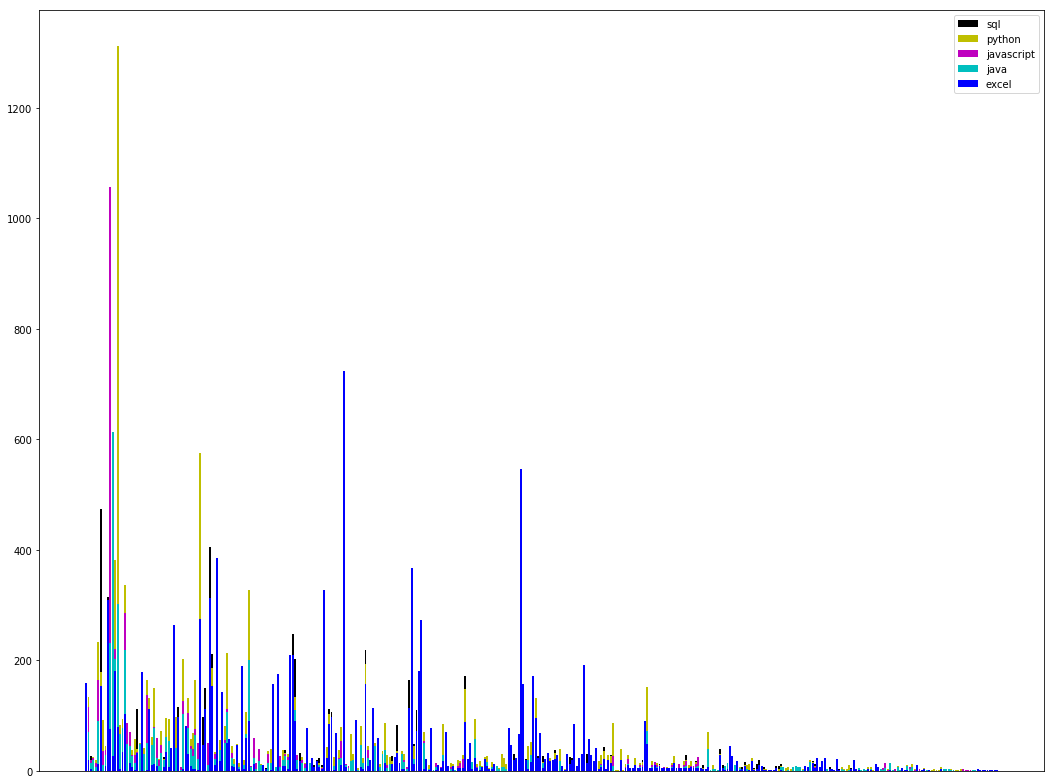

In [89]:
colors = list("rgbcmyk")
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18,14)

for data_dict in all_matches.values():
   x = data_dict.keys()
   y = data_dict.values()
   plt.bar(x,y,color=colors.pop())

plt.legend(all_matches.keys())
plt.xticks([])
plt.show()

In [91]:
for skill, c in all_matches.items():
    most_common = c.most_common(20)
    print(skill, "SUMMARY:")
    print('~~~~~~~~~~~~~~~~~~~~~')
    for item, freq in most_common:
        print(item, "+" * (freq//10))
    print()

sql SUMMARY:
~~~~~~~~~~~~~~~~~~~~~
analysis +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
sql +++++++++++++++++++++++++++++++++++++++++++++++
analytics ++++++++++++++++++++++++++++++++++++++++
python +++++++++++++++++++++++++++++++++++
development +++++++++++++++++++++++++++++++
engineering +++++++++++++++++++++++++++++
communication +++++++++++++++++++++++++++
software +++++++++++++++++++++++++++
analyze +++++++++++++++++++++++++
analysts ++++++++++++++++++++++++
web ++++++++++++++++++++++++
programming ++++++++++++++++++++++++
javascript ++++++++++++++++++++++++
modeling +++++++++++++++++++++++
analyst ++++++++++++++++++++++
design +++++++++++++++++++++
statistics +++++++++++++++++++++
analytical ++++++++++++++++++++
agile ++++++++++++++++++++
visualization +++++++++++++++++

python SUMMARY:
~~~~~~~~~~~~~~~~~~~~~
python +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
engineering ++++++++++